In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [38]:
df = pd.read_csv('../datasets/bank-full.csv', sep=';')

In [39]:
no_current_features = [
    'default', 'loan'
]

df = df.drop(columns=no_current_features)

df.y = (df.y == 'yes').astype(int)

df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [40]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [41]:
numerical = [
    'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'
]

categorical = [
    'job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome'
]

Question 1: ROC AUC feature importance

In [42]:
from sklearn.metrics import roc_auc_score

scores = {}

for i in numerical:
    auc = roc_auc_score(y_train, df_train[i])
    if auc <  5:
        auc = roc_auc_score(y_train, -df_train[i])
    scores[i] = auc

result = [key for key,value in scores.items() if value==max(scores.values())]
#result
scores

{'age': np.float64(0.512185717527344),
 'balance': np.float64(0.41116861946176825),
 'day': np.float64(0.525957882383908),
 'duration': np.float64(0.18529972403292225),
 'campaign': np.float64(0.5714543015682159),
 'pdays': np.float64(0.4098723752647857),
 'previous': np.float64(0.40143467572358477)}

Question 2: Training the model

In [43]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [45]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [50]:
roc_auc_score(y_val, y_pred).round(3)

np.float64(0.901)

Question 3: Precision and Recall

C:\Users\knuck\AppData\Local\Temp\ipykernel_8216\1525480197.py:21: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


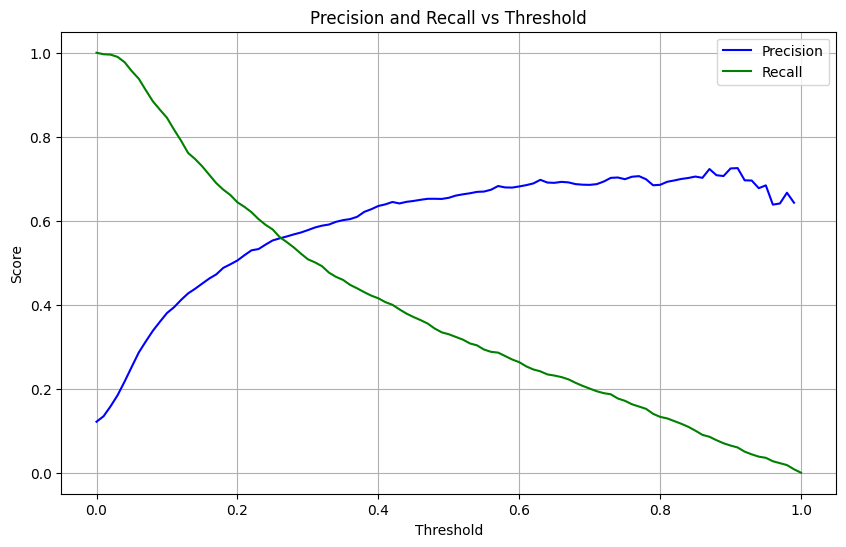

In [61]:
from sklearn.metrics import accuracy_score, recall_score

precisions = []
recalls = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    precisions.append(p)

    r = tp / (tp + fn)
    recalls.append(r)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="green")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

Question 4: F1 score

In [70]:
thresholds = np.linspace(0, 1, 101)

f1s = {}

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)

    r = tp / (tp + fn)

    f1 = 2 * ((p * r) / (p + r))
    f1s[str(t)] = (f1.round(3))

#f1s
[key for key, value in f1s.items() if value == max(f1s.values())]

C:\Users\knuck\AppData\Local\Temp\ipykernel_8216\373367666.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


['0.22']

Question 5: 5-Fold CV

In [89]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [91]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

np.std(scores)

np.float64(0.005691215739889739)

In [76]:
!pip install tqdm
from tqdm.auto import tqdm


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Program Files\ProjectsCode\ml-course\ml-zoomcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Question 6: Hyperparameter Tuning

In [93]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    # + mean = better score, - std = less variability
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 33%|████████                | 1/3 [00:03<00:07,  3.89s/it]

C=1e-06 0.701 +- 0.009


 67%|████████████████        | 2/3 [00:08<00:04,  4.41s/it]

C=0.001 0.861 +- 0.007


100%|████████████████████████| 3/3 [00:14<00:00,  4.71s/it]

C=1 0.906 +- 0.006
